### Clean and Merge BHRC data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import pyreadr, pyreadstat
import seaborn as sns
import statsmodels.api as sm
import sys
import warnings

from datetime import datetime

from plotnine import *
from pyprojroot import here
from scipy import stats

sys.path.insert(0, f"{here()}/src")
from plots import scatter_predicted_chronological, scatter_adjbrainage_age, age_distribution_plot
from prep_columns import clean_columns
from test import test

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.reset_option("mode.chained_assignment")

In [2]:
datem = datetime.today().strftime("%Y-%m-%d")

In [3]:
df_raw = pd.read_csv(f'{here()}/data/raw/bhrc/BHRC_20241205_FS_aparc_merged_fs_stats.txt', sep="\t", index_col=0) 
#pheno = pd.read_csv(f'{here()}/data/raw/bhrc/BHRC_pheno_20240329.csv', low_memory=False)
qoalaT = pd.read_csv(f'{here()}/data/raw/bhrc/BHRC_QoalaT_predictions.csv')
qoalaT2 = pd.read_csv(f'{here()}/data/raw/bhrc/BHRC_BHRC2_Qoala_T_predictions.csv')
qoalaT3 = pd.read_csv(f'{here()}/data/raw/bhrc/BHRC3_QoalaT_predictions.csv')
phenoUher, meta = pyreadstat.read_sav(f'{here()}/data/raw/bhrc/Uher_193BHRC_2024_08_17.sav')

In [4]:
df_raw.columns = df_raw.columns.str.lower().str.replace('-', '_')
qoalaT.columns = qoalaT.columns.str.lower()
qoalaT2.columns = qoalaT2.columns.str.lower()
qoalaT3.columns = qoalaT3.columns.str.lower()

In [5]:
df_raw = df_raw[df_raw['project'].str.contains('BHRC')]

In [6]:
df_raw.shape

(1619, 620)

#### Clean Age dataframe

In [7]:
age = pyreadr.read_r(f"{here()}/data/raw/bhrc/bhrc_scan_age.rds")
age_df = age[None]

In [8]:
def determine_category(row):
    if row['redcap_event_name'] == 'wave0_arm_1':
        return 'BHRC'
    elif row['redcap_event_name'] == 'wave1_arm_1':
        return 'BHRC2'
    else:
        return 'BHRC3'
    
age_df['site'] = age_df.apply(determine_category, axis=1)

In [9]:
age_df.head()

,ident,redcap_event_name,age,nage,d_sample,p_sample,n_sample,f_sample,dpn_sample,site
0,1.0,wave0_arm_1,7.033539,NaN,1.0,0.0,0.0,1.0,1.0,BHRC
1,1.0,wave1_arm_1,10.800821,NaN,1.0,1.0,0.0,0.0,1.0,BHRC2
2,1.0,wave2_arm_1,15.635866,NaN,1.0,1.0,0.0,0.0,1.0,BHRC3
3,2.0,wave0_arm_1,7.058179,NaN,1.0,0.0,0.0,1.0,1.0,BHRC
4,2.0,wave1_arm_1,10.132786,NaN,1.0,1.0,0.0,0.0,1.0,BHRC2


In [10]:
age_df.rename(columns={'nage': 'scan_age', 'ident': 'scan_id'}, inplace=True)

In [11]:
nage_df = age_df[age_df['scan_age'].notnull()]
nage_df.loc[:, 'scan_id'] = nage_df['scan_id'].astype('int64')

In [12]:
nage_df.shape

(1695, 10)

In [13]:
nage_df.shape

(1695, 10)

#### Merge with age and qoalaT dataframes

In [14]:
df_raw['scan_id'] = df_raw['scan_id'].str.split("-").str[1]
qoalaT['scan_id'] = qoalaT['scan_id'].str.split("-").str[1]
qoalaT2['scan_id'] = qoalaT2['scan_id'].str.split("-").str[1]
qoalaT3['scan_id'] = qoalaT3['scan_id'].str.split("-").str[1]

In [15]:
qoalaT['site'] = 'BHRC'
qoalaT2['site'] = 'BHRC2'
qoalaT3['site'] = 'BHRC3'

In [16]:
qoalaT_df = pd.concat([qoalaT, qoalaT2, qoalaT3], ignore_index=True)
df = df_raw.merge(qoalaT_df, on=['scan_id', 'site'], how='left')

In [17]:
df['scan_id'] = df['scan_id'].astype('int64')

In [18]:
df2 = pd.merge(nage_df, df, on=['scan_id', 'site'] , how='right')

In [19]:
df2.shape, df_raw.shape

((1619, 631), (1619, 620))

In [20]:
df2.sample(3)

,scan_id,redcap_event_name,age,scan_age,d_sample,p_sample,n_sample,f_sample,dpn_sample,site,unnamed: 0,project,measure:volume,left_lateral_ventricle,left_inf_lat_vent,left_cerebellum_white_matter,left_cerebellum_cortex,left_thalamus_proper,left_caudate,left_putamen,left_pallidum,3rd_ventricle,4th_ventricle,brain_stem,left_hippocampus,left_amygdala,csf,left_accumbens_area,left_ventraldc,left_vessel,left_choroid_plexus,right_lateral_ventricle,right_inf_lat_vent,right_cerebellum_white_matter,right_cerebellum_cortex,right_thalamus_proper,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens_area,right_ventraldc,right_vessel,right_choroid_plexus,5th_ventricle,wm_hypointensities,left_wm_hypointensities,right_wm_hypointensities,non_wm_hypointensities,left_non_wm_hypointensities,right_non_wm_hypointensities,optic_chiasm,cc_posterior,cc_mid_posterior,cc_central,cc_mid_anterior,cc_anterior,brainsegvol,brainsegvolnotvent,brainsegvolnotventsurf,lhcortexvol,rhcortexvol,cortexvol,lhcerebralwhitemattervol,rhcerebralwhitemattervol,cerebralwhitemattervol,subcortgrayvol,totalgrayvol,supratentorialvol,supratentorialvolnotvent,supratentorialvolnotventvox,maskvol,brainsegvol_to_etiv,maskvol_to_etiv,lhsurfaceholes,rhsurfaceholes,surfaceholes,estimatedtotalintracranialvol,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,lh_lateralorbitofrontal_area,lh_lingual_area,lh_medialorbitofrontal_area,lh_middletemporal_area,lh_parahippocampal_area,lh_paracentral_area,lh_parsopercularis_area,lh_parsorbitalis_area,lh_parstriangularis_area,lh_pericalcarine_area,lh_postcentral_area,lh_posteriorcingulate_area,lh_precentral_area,lh_precuneus_area,lh_rostralanteriorcingulate_area,lh_rostralmiddlefrontal_area,lh_superiorfrontal_area,lh_superiorparietal_area,lh_superiortemporal_area,lh_supramarginal_area,lh_frontalpole_area,lh_temporalpole_area,lh_transversetemporal_area,lh_insula_area,lh_whitesurfarea_area,etiv,rh_bankssts_area,rh_caudalanteriorcingulate_area,rh_caudalmiddlefrontal_area,rh_cuneus_area,rh_entorhinal_area,rh_fusiform_area,rh_inferiorparietal_area,rh_inferiortemporal_area,rh_isthmuscingulate_area,rh_lateraloccipital_area,rh_lateralorbitofrontal_area,rh_lingual_area,rh_medialorbitofrontal_area,rh_middletemporal_area,rh_parahippocampal_area,rh_paracentral_area,rh_parsopercularis_area,rh_parsorbitalis_area,rh_parstriangularis_area,rh_pericalcarine_area,rh_postcentral_area,rh_posteriorcingulate_area,rh_precentral_area,rh_precuneus_area,rh_rostralanteriorcingulate_area,rh_rostralmiddlefrontal_area,rh_superiorfrontal_area,rh_superiorparietal_area,rh_superiortemporal_area,rh_supramarginal_area,rh_frontalpole_area,rh_temporalpole_area,rh_transversetemporal_area,rh_insula_area,rh_whitesurfarea_area,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_meanthickness_thickness,rh_bankssts_thickness,rh_caudalanteriorcingulate_thickness,rh_caudalmiddlefrontal_thickn

#### Merge with phenotype data

In [21]:
waves = ['wave0_arm_1', 'wave1_arm_1', 'wave2_arm_1']
wave = phenoUher[phenoUher['redcap_event_name'].isin(waves)]

In [22]:
wave['redcap_event_name'].value_counts()

redcap_event_name
wave0_arm_1    2511
wave1_arm_1    2511
wave2_arm_1    2511
Name: count, dtype: int64

In [23]:
wave.sample(3)

ident redcap_event_name birth_date_original  site_original  \
4244  1062.0       wave0_arm_1          2001-01-06            1.0   
554    139.0       wave2_arm_1          1999-06-28            1.0   
5984  1497.0       wave0_arm_1          2000-08-17            2.0   

      gender_original  site  gender  birth_date birth_mother birth_father  \
4244              1.0   1.0     1.0  2001-01-06   1972-04-23          NaN   
554               2.0   1.0     2.0  1999-06-28   1954-06-18          NaN   
5984              2.0   2.0     2.0  2000-08-17   1971-11-23          NaN   

      skincolor  mskincolor  fskincolor  selection        age        agem  \
4244        3.0         1.0         1.0        2.0   9.798768  117.585216   
554         3.0         3.0         3.0        1.0  20.383299  244.599589   
5984        3.0         3.0         2.0        1.0  10.151951  121.823409   

          page1      page1m      page2      page2m       nage       nagem  \
4244   9.905544  118.866530   9.913758  118.965092  10.907598  130.891170   
554   20.314853  243.778234  20.314853  243.778234        NaN         NaN   
5984  10.234086  122.809035  10.236824  122.841889  11.047228  132.566735   

           fage       fagem  p1dawbaage  sdawbaage       bage       bagem  \
4244   9.842574  118.110883   10.130048        NaN  10.907598  118.866530   
554         NaN         NaN   20.383299  20.314853  20.314853  243.778234   
5984  10.195756  122.349076   10.291581        NaN  11.047228  122.809035   

      mother_age  mother_age_atbirth  father_age      d_date d_houri d_hourf  \
4244   38.505133           28.706366         NaN  2010-10-25   14:00   16:15   
554    65.409993           45.026694         NaN  2019-11-15   10:13   11:54   
5984   38.885695           28.733744         NaN  2010-10-12   10:40   12:20   

         p_date1  p_weekday1 p_houri1 p_hourf1     p_date2  p_weekday2  \
4244  2010-12-03        14.0    14:00    14:40  2010-12-06        10.0   
554   2019-10-21         2.0    08:29    10:14  2019-10-21         2.0   
5984  2010-11-11        13.0    17:04    17:50  2010-11-12        14.0   

     p_houri2 p_hourf2      f_date     np_date   np_houri   np_hourf  \
4244    14:35    15:20  2010-11-10  2011-12-04  7/17/2013  7/17/2013   
554     10:14    10:33         NaN         NaN                         
5984    16:00    16:30  2010-10-28  2011-09-04  7/17/2013              

         nc_date    nc_houri    nc_hourf  fittedval    weight nc_date_w2  \
4244  2011-12-04  10/30/2013  10/30/2013   0.360465  1.477341        NaN   
554          NaN                           0.683283  2.598846        NaN   
5984  2011-09-04  10/30/2013  10/30/2013   0.876983  2.621086        NaN   

      follow_dom_w0w1  follow_psi1_w0w1  follow_psi2_w0w1  follow_neu_w0w1  \
4244         3.301848          3.715264          3.775496              NaN   
554               NaN               NaN               NaN              NaN   
5984         3.342916          3.400411          3.397673         3.564682   

      follow_fon_w0w1  follow_dom_w0w2  follow_psi1_w0w2  follow_psi2_w0w2  \
4244         3.778234         8.177960          8.164271          8.156057   
554               NaN         8.966461          8.361396          8.361396   
5984         3.438741         7.586585          7.589322          7.734428   

      follow_neu_w0w2  follow_fon_w0w2  interval_dn  interval_dp1  \
4244         6.505133         8.227242    13.305955      1.281314   
554               NaN         8.380561          NaN     -0.821355   
5984         6.861054         7.627652    10.743326      0.985626   

      interval_dp2  interval_p1p2  d_sample  p_sample  n_sample  f_sample  \
4244      1.379877       0.098563       1.0       1.0       1.0       1.0   
554      -0.821355       0.000000       1.0       1.0       0.0       0.0   
5984      1.018480       0.032854       1.0       1.0       1.0       1.0   

      dpn_sample  d_length  p_length1  p_length2  p_lengtht  page_grou

In [24]:
wave.rename(columns={'nage': 'pheno_age', 'gender': 'sex', 'ident': 'scan_id', 'page1': 'psych_interview_age', "dcmania": "bpd", \
                    'selection': 'group', 'dcanydep': 'depression', 'p_kalu_pre': 'cantpsych', 'p_kalu_pas': 'past_antpsych', 'dq': 'iq', \
                        'dcanyhk': 'adhd', 'dcanyanx': 'anxiety'}, inplace=True)

/var/folders/7w/4mwg2xbx4j9645_p5tvccmph0000gn/T/ipykernel_7215/73708371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
wave.loc[:, 'sex'] = wave['sex'].map({1: 'Male', 2: 'Female'})
wave.loc[:, 'scan_id'] = wave['scan_id'].astype('int64')
wave.loc[:, 'group'] = wave['group'].map({1.0: 'Ctrls', 2.0: 'FHR (SMI)'})

In [26]:
pheno_neuro_wave_one = wave[wave['pheno_age'].notnull()]

In [27]:
wave[['scan_id', 'sex', 'redcap_event_name', 'group', 'pheno_age', 'depression', 'cantpsych', 'past_antpsych', 'iq', 'adhd', 'anxiety', 'psych_interview_age']].head()

,scan_id,sex,redcap_event_name,group,pheno_age,depression,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age
0,1.0,Female,wave0_arm_1,Ctrls,NaN,0.0,NaN,NaN,NaN,2.0,2.0,NaN
1,1.0,Female,wave1_arm_1,Ctrls,NaN,0.0,NaN,NaN,NaN,0.0,0.0,10.932238
2,1.0,Female,wave2_arm_1,Ctrls,NaN,0.0,NaN,NaN,NaN,0.0,0.0,15.808350
4,2.0,Male,wave0_arm_1,Ctrls,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
5,2.0,Male,wave1_arm_1,Ctrls,NaN,0.0,NaN,NaN,NaN,0.0,2.0,10.784394


In [28]:
pheno = wave[["scan_id", "pheno_age", "redcap_event_name", "sex", "group", "depression", "cantpsych", "dcany", "bpd", 
                    "past_antpsych", "iq", "adhd", "anxiety", "psych_interview_age"]]

In [29]:
wave.head()

scan_id redcap_event_name birth_date_original  site_original  \
0      1.0       wave0_arm_1          2003-10-26            1.0   
1      1.0       wave1_arm_1          2003-10-26            1.0   
2      1.0       wave2_arm_1          2003-10-26            1.0   
4      2.0       wave0_arm_1          2003-10-15            1.0   
5      2.0       wave1_arm_1          2003-10-15            1.0   

   gender_original  site     sex  birth_date birth_mother birth_father  \
0              2.0   1.0  Female  2003-10-26   1983-03-01   1976-03-01   
1              2.0   1.0  Female  2003-10-26   1983-03-01   1976-03-01   
2              2.0   1.0  Female  2003-10-26   1983-03-01   1976-03-01   
4              1.0   1.0    Male  2003-10-15   1976-01-21   1957-04-06   
5              1.0   1.0    Male  2003-10-15   1976-01-21   1957-04-06   

   skincolor  mskincolor  fskincolor  group        age        agem  \
0        1.0         1.0         3.0  Ctrls   7.033539   84.402464   
1        1.0         1.0         3.0  Ctrls  10.800821  129.609856   
2        1.0         1.0         3.0  Ctrls  15.635866  187.630390   
4        2.0         2.0         1.0  Ctrls   7.058179   84.698152   
5        2.0         2.0         1.0  Ctrls  10.132786  121.593429   

   psych_interview_age      page1m      page2      page2m  pheno_age  nagem  \
0                  NaN         NaN        NaN         NaN        NaN    NaN   
1            10.932238  131.186858  10.932238  131.186858        NaN    NaN   
2            15.808350  189.700205  15.808350  189.700205        NaN    NaN   
4                  NaN         NaN        NaN         NaN        NaN    NaN   
5            10.784394  129.412731  10.789870  129.478439        NaN    NaN   

       fage      fagem  p1dawbaage  sdawbaage      bage       bagem  \
0  7.099247  85.190965    7.066393        NaN       NaN         NaN   
1       NaN        NaN   10.937714  11.696099       NaN  131.186858   
2       NaN        NaN   15.635866  15.808350  15.80835  189.700205   
4  7.474333  89.691992    7.099247        NaN       NaN         NaN   
5       NaN        NaN   10.800821  11.682409       NaN  129.412731   

   mother_age  mother_age_atbirth  father_age      d_date d_houri d_hourf  \
0   27.687885           20.654346   34.685832  2010-11-07   08:00   11:10   
1   31.455168           20.654346   38.453114  2014-08-14   14:00   15:15   
2   36.290212           20.654346   43.288159  2019-06-15   10:00   11:44   
4   34.789870           27.731691   53.582478  2010-11-05   12:45   14:25   
5   37.864476           27.731691   56.657084  2013-12-02   13:25   14:43   

      p_date1  p_weekday1 p_houri1 p_hourf1     p_date2  p_weekday2 p_houri2  \
0         NaN         NaN                           NaN         NaN            
1  2014-10-01         4.0    10:40    11:20  2014-10-01         4.0    11:20   
2  2019-08-17         7.0    08:13    09:24  2019-08-17         7.0    09:31   
4         NaN         NaN                           NaN         NaN            
5  2014-07-28         2.0    08:37    11:16  2014-07-30         4.0    11:02   

  p_hourf2      f_date np_date np_houri np_hourf nc_date nc_houri nc_hourf  \
0           2010-12-01     NaN                       NaN                     
1    11:21         NaN     NaN                       NaN                     
2    09:59         NaN     NaN                       NaN                     
4           2011-04-06     NaN                       NaN                     
5    12:18         NaN     NaN                       NaN                     

   fittedval    weight nc_date_w2  follow_dom_w0w1  follow_psi1_w0w1  \
0   0.777985  2.621086        NaN         3.767283               NaN   
1   0.799342  2.617188        NaN         3.767283               NaN   
2   0.756476  2.598846        NaN         3.767283               NaN   
4   0.206937  2.621086        NaN         3.074606               NaN   
5   0.250055  2.617188        NaN         3.074606         

In [30]:
mri = pd.merge(pheno, df2, on=['scan_id', "redcap_event_name"] , how='right')

In [31]:
mri.head()

,scan_id,pheno_age,redcap_event_name,sex,group,depression,cantpsych,dcany,bpd,past_antpsych,iq,adhd,anxiety,psych_interview_age,age,scan_age,d_sample,p_sample,n_sample,f_sample,dpn_sample,site,unnamed: 0,project,measure:volume,left_lateral_ventricle,left_inf_lat_vent,left_cerebellum_white_matter,left_cerebellum_cortex,left_thalamus_proper,left_caudate,left_putamen,left_pallidum,3rd_ventricle,4th_ventricle,brain_stem,left_hippocampus,left_amygdala,csf,left_accumbens_area,left_ventraldc,left_vessel,left_choroid_plexus,right_lateral_ventricle,right_inf_lat_vent,right_cerebellum_white_matter,right_cerebellum_cortex,right_thalamus_proper,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens_area,right_ventraldc,right_vessel,right_choroid_plexus,5th_ventricle,wm_hypointensities,left_wm_hypointensities,right_wm_hypointensities,non_wm_hypointensities,left_non_wm_hypointensities,right_non_wm_hypointensities,optic_chiasm,cc_posterior,cc_mid_posterior,cc_central,cc_mid_anterior,cc_anterior,brainsegvol,brainsegvolnotvent,brainsegvolnotventsurf,lhcortexvol,rhcortexvol,cortexvol,lhcerebralwhitemattervol,rhcerebralwhitemattervol,cerebralwhitemattervol,subcortgrayvol,totalgrayvol,supratentorialvol,supratentorialvolnotvent,supratentorialvolnotventvox,maskvol,brainsegvol_to_etiv,maskvol_to_etiv,lhsurfaceholes,rhsurfaceholes,surfaceholes,estimatedtotalintracranialvol,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,lh_lateralorbitofrontal_area,lh_lingual_area,lh_medialorbitofrontal_area,lh_middletemporal_area,lh_parahippocampal_area,lh_paracentral_area,lh_parsopercularis_area,lh_parsorbitalis_area,lh_parstriangularis_area,lh_pericalcarine_area,lh_postcentral_area,lh_posteriorcingulate_area,lh_precentral_area,lh_precuneus_area,lh_rostralanteriorcingulate_area,lh_rostralmiddlefrontal_area,lh_superiorfrontal_area,lh_superiorparietal_area,lh_superiortemporal_area,lh_supramarginal_area,lh_frontalpole_area,lh_temporalpole_area,lh_transversetemporal_area,lh_insula_area,lh_whitesurfarea_area,etiv,rh_bankssts_area,rh_caudalanteriorcingulate_area,rh_caudalmiddlefrontal_area,rh_cuneus_area,rh_entorhinal_area,rh_fusiform_area,rh_inferiorparietal_area,rh_inferiortemporal_area,rh_isthmuscingulate_area,rh_lateraloccipital_area,rh_lateralorbitofrontal_area,rh_lingual_area,rh_medialorbitofrontal_area,rh_middletemporal_area,rh_parahippocampal_area,rh_paracentral_area,rh_parsopercularis_area,rh_parsorbitalis_area,rh_parstriangularis_area,rh_pericalcarine_area,rh_postcentral_area,rh_posteriorcingulate_area,rh_precentral_area,rh_precuneus_area,rh_rostralanteriorcingulate_area,rh_rostralmiddlefrontal_area,rh_superiorfrontal_area,rh_superiorparietal_area,rh_superiortemporal_area,rh_supramarginal_area,rh_frontalpole_area,rh_temporalpole_area,rh_transversetemporal_area,rh_insula_area,rh_whitesurfarea_area,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_meanthickne

In [32]:
mri.scan_age.describe()

count    1619.000000
mean       13.320730
std         5.955663
min       -99.906913
25%        10.744695
50%        13.259411
75%        16.202601
max        22.466804
Name: scan_age, dtype: float64

#### Drop 3 participants with scan ages < 0 and 116 with poor quality scans

In [33]:
mri.recommendation.value_counts()

recommendation
Include    1503
Exclude     116
Name: count, dtype: int64

In [34]:
mri_pheno = mri[mri['scan_age'] > 0]

In [35]:
mri_pheno = mri_pheno[mri_pheno['recommendation'] == "Include"]

In [36]:
mri_pheno.shape, mri.shape

((1500, 643), (1619, 643))

/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


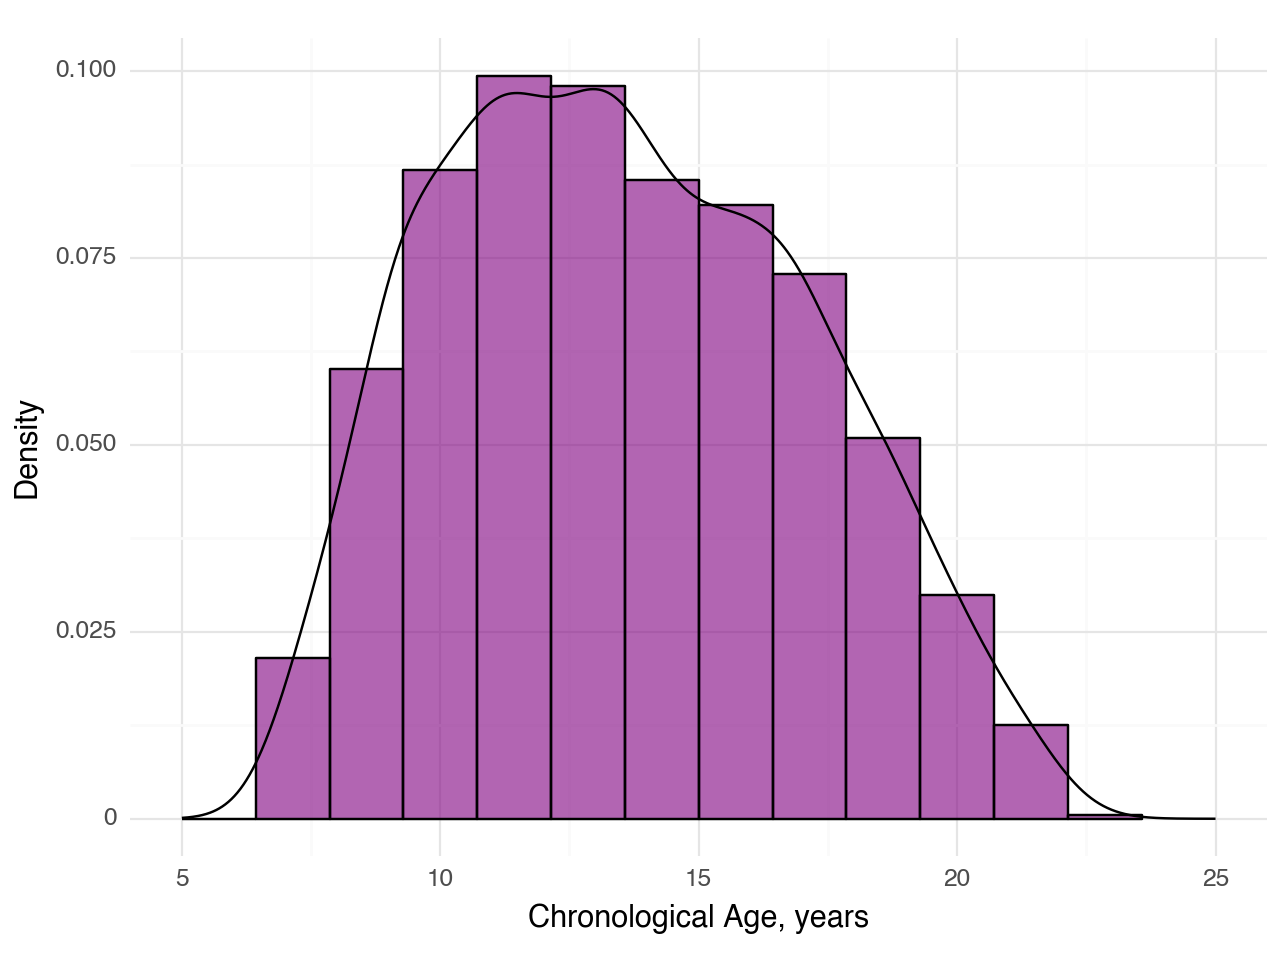

In [37]:
plot = (
    ggplot(mri_pheno, aes(x='scan_age')) +
    geom_histogram(aes(y='..density..'), fill=f'purple', bins=15, alpha=0.6, color='black') + 
    geom_density(color='black', alpha=0.5) + 
    xlab('Chronological Age, years') +
    ylab('Density') + 
    theme_minimal() +
    xlim(5, 25))

print(plot)

#plot.save(f"{here()}/figures/bhrc3_age_distribution.png", dpi=800)

In [38]:
mri_pheno.head()

,scan_id,pheno_age,redcap_event_name,sex,group,depression,cantpsych,dcany,bpd,past_antpsych,iq,adhd,anxiety,psych_interview_age,age,scan_age,d_sample,p_sample,n_sample,f_sample,dpn_sample,site,unnamed: 0,project,measure:volume,left_lateral_ventricle,left_inf_lat_vent,left_cerebellum_white_matter,left_cerebellum_cortex,left_thalamus_proper,left_caudate,left_putamen,left_pallidum,3rd_ventricle,4th_ventricle,brain_stem,left_hippocampus,left_amygdala,csf,left_accumbens_area,left_ventraldc,left_vessel,left_choroid_plexus,right_lateral_ventricle,right_inf_lat_vent,right_cerebellum_white_matter,right_cerebellum_cortex,right_thalamus_proper,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens_area,right_ventraldc,right_vessel,right_choroid_plexus,5th_ventricle,wm_hypointensities,left_wm_hypointensities,right_wm_hypointensities,non_wm_hypointensities,left_non_wm_hypointensities,right_non_wm_hypointensities,optic_chiasm,cc_posterior,cc_mid_posterior,cc_central,cc_mid_anterior,cc_anterior,brainsegvol,brainsegvolnotvent,brainsegvolnotventsurf,lhcortexvol,rhcortexvol,cortexvol,lhcerebralwhitemattervol,rhcerebralwhitemattervol,cerebralwhitemattervol,subcortgrayvol,totalgrayvol,supratentorialvol,supratentorialvolnotvent,supratentorialvolnotventvox,maskvol,brainsegvol_to_etiv,maskvol_to_etiv,lhsurfaceholes,rhsurfaceholes,surfaceholes,estimatedtotalintracranialvol,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,lh_lateralorbitofrontal_area,lh_lingual_area,lh_medialorbitofrontal_area,lh_middletemporal_area,lh_parahippocampal_area,lh_paracentral_area,lh_parsopercularis_area,lh_parsorbitalis_area,lh_parstriangularis_area,lh_pericalcarine_area,lh_postcentral_area,lh_posteriorcingulate_area,lh_precentral_area,lh_precuneus_area,lh_rostralanteriorcingulate_area,lh_rostralmiddlefrontal_area,lh_superiorfrontal_area,lh_superiorparietal_area,lh_superiortemporal_area,lh_supramarginal_area,lh_frontalpole_area,lh_temporalpole_area,lh_transversetemporal_area,lh_insula_area,lh_whitesurfarea_area,etiv,rh_bankssts_area,rh_caudalanteriorcingulate_area,rh_caudalmiddlefrontal_area,rh_cuneus_area,rh_entorhinal_area,rh_fusiform_area,rh_inferiorparietal_area,rh_inferiortemporal_area,rh_isthmuscingulate_area,rh_lateraloccipital_area,rh_lateralorbitofrontal_area,rh_lingual_area,rh_medialorbitofrontal_area,rh_middletemporal_area,rh_parahippocampal_area,rh_paracentral_area,rh_parsopercularis_area,rh_parsorbitalis_area,rh_parstriangularis_area,rh_pericalcarine_area,rh_postcentral_area,rh_posteriorcingulate_area,rh_precentral_area,rh_precuneus_area,rh_rostralanteriorcingulate_area,rh_rostralmiddlefrontal_area,rh_superiorfrontal_area,rh_superiorparietal_area,rh_superiortemporal_area,rh_supramarginal_area,rh_frontalpole_area,rh_temporalpole_area,rh_transversetemporal_area,rh_insula_area,rh_whitesurfarea_area,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_meanthickne

In [39]:
pheno.pheno_age.isna().sum()

5837

In [40]:
mri_pheno.site.value_counts()

site
BHRC     674
BHRC2    439
BHRC3    387
Name: count, dtype: int64

In [41]:
pheno_data = mri_pheno[["scan_id", "scan_age", "sex", "site", "group", "depression", "bpd", \
                        "cantpsych", "past_antpsych", "iq", "adhd", "anxiety", "psych_interview_age", "pheno_age"]]

In [42]:
pheno_data.head()

,scan_id,scan_age,sex,site,group,depression,bpd,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age,pheno_age
0,3.0,8.856947,Female,BHRC,Ctrls,0.0,0.0,1.0,1.0,94.0,0.0,0.0,8.591376,8.856947
2,15.0,12.848734,Female,BHRC,Ctrls,2.0,0.0,0.0,0.0,85.0,0.0,0.0,12.514716,12.848734
3,16.0,12.013689,Male,BHRC,FHR (SMI),0.0,0.0,1.0,1.0,100.0,2.0,2.0,11.718001,12.013689
4,19.0,12.000000,Female,BHRC,FHR (SMI),0.0,0.0,1.0,1.0,75.0,0.0,0.0,11.044490,12.000000
5,22.0,14.425736,Female,BHRC,Ctrls,0.0,0.0,1.0,1.0,91.0,0.0,0.0,13.459274,14.425736


In [43]:
bhrc_mri = mri_pheno.drop(columns=["scan_id", "sex", "group", "depression", "bpd", "cantpsych", "past_antpsych", \
                        "iq", "adhd", "anxiety", "psych_interview_age", "pheno_age", \
                            "d_sample", "p_sample", "n_sample", "f_sample", "site", "project",
                            "redcap_event_name", "age", "dpn_sample", "unnamed: 0", "measure:volume",
                            "qoala_t_score", "recommendation", "manual_qc_advised"])

In [44]:
bhrc_mri.head()

,dcany,scan_age,left_lateral_ventricle,left_inf_lat_vent,left_cerebellum_white_matter,left_cerebellum_cortex,left_thalamus_proper,left_caudate,left_putamen,left_pallidum,3rd_ventricle,4th_ventricle,brain_stem,left_hippocampus,left_amygdala,csf,left_accumbens_area,left_ventraldc,left_vessel,left_choroid_plexus,right_lateral_ventricle,right_inf_lat_vent,right_cerebellum_white_matter,right_cerebellum_cortex,right_thalamus_proper,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens_area,right_ventraldc,right_vessel,right_choroid_plexus,5th_ventricle,wm_hypointensities,left_wm_hypointensities,right_wm_hypointensities,non_wm_hypointensities,left_non_wm_hypointensities,right_non_wm_hypointensities,optic_chiasm,cc_posterior,cc_mid_posterior,cc_central,cc_mid_anterior,cc_anterior,brainsegvol,brainsegvolnotvent,brainsegvolnotventsurf,lhcortexvol,rhcortexvol,cortexvol,lhcerebralwhitemattervol,rhcerebralwhitemattervol,cerebralwhitemattervol,subcortgrayvol,totalgrayvol,supratentorialvol,supratentorialvolnotvent,supratentorialvolnotventvox,maskvol,brainsegvol_to_etiv,maskvol_to_etiv,lhsurfaceholes,rhsurfaceholes,surfaceholes,estimatedtotalintracranialvol,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,lh_lateralorbitofrontal_area,lh_lingual_area,lh_medialorbitofrontal_area,lh_middletemporal_area,lh_parahippocampal_area,lh_paracentral_area,lh_parsopercularis_area,lh_parsorbitalis_area,lh_parstriangularis_area,lh_pericalcarine_area,lh_postcentral_area,lh_posteriorcingulate_area,lh_precentral_area,lh_precuneus_area,lh_rostralanteriorcingulate_area,lh_rostralmiddlefrontal_area,lh_superiorfrontal_area,lh_superiorparietal_area,lh_superiortemporal_area,lh_supramarginal_area,lh_frontalpole_area,lh_temporalpole_area,lh_transversetemporal_area,lh_insula_area,lh_whitesurfarea_area,etiv,rh_bankssts_area,rh_caudalanteriorcingulate_area,rh_caudalmiddlefrontal_area,rh_cuneus_area,rh_entorhinal_area,rh_fusiform_area,rh_inferiorparietal_area,rh_inferiortemporal_area,rh_isthmuscingulate_area,rh_lateraloccipital_area,rh_lateralorbitofrontal_area,rh_lingual_area,rh_medialorbitofrontal_area,rh_middletemporal_area,rh_parahippocampal_area,rh_paracentral_area,rh_parsopercularis_area,rh_parsorbitalis_area,rh_parstriangularis_area,rh_pericalcarine_area,rh_postcentral_area,rh_posteriorcingulate_area,rh_precentral_area,rh_precuneus_area,rh_rostralanteriorcingulate_area,rh_rostralmiddlefrontal_area,rh_superiorfrontal_area,rh_superiorparietal_area,rh_superiortemporal_area,rh_supramarginal_area,rh_frontalpole_area,rh_temporalpole_area,rh_transversetemporal_area,rh_insula_area,rh_whitesurfarea_area,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_meanthickness_thickness,rh_bankssts_thickness,rh_caudalanteriorcingulate_thickness,rh_caudalmiddlefrontal_thickness,rh_cuneus_thickness,rh_entorhinal_thickness,rh_fusiform_thickness,rh_inferiorparietal_thickness,rh_inferio

In [45]:
bhrc_mri.shape

(1500, 617)

#### Test and age correct BHRC data

In [46]:
bhrc_mri.scan_age.describe()

count    1500.000000
mean       13.593783
std         3.478887
min         6.715948
25%        10.800137
50%        13.329227
75%        16.286790
max        22.466804
Name: scan_age, dtype: float64

In [47]:
mri = clean_columns(bhrc_mri)

(1500, 187)


In [48]:
mri.shape, pheno_data.shape

((1500, 187), (1500, 14))

In [49]:
pheno_data.head(3)

,scan_id,scan_age,sex,site,group,depression,bpd,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age,pheno_age
0,3.0,8.856947,Female,BHRC,Ctrls,0.0,0.0,1.0,1.0,94.0,0.0,0.0,8.591376,8.856947
2,15.0,12.848734,Female,BHRC,Ctrls,2.0,0.0,0.0,0.0,85.0,0.0,0.0,12.514716,12.848734
3,16.0,12.013689,Male,BHRC,FHR (SMI),0.0,0.0,1.0,1.0,100.0,2.0,2.0,11.718001,12.013689


In [50]:
mri['scan_age'] = pheno_data['scan_age']
mri['scan_id'] = pheno_data['scan_id']

In [51]:
mri.shape

(1500, 189)

In [52]:
df_result = test(mri, sex='all')

(1500, 187)
MAE: 2.3012059493005044
Adjusted MAE: 2.38265525354361
Correlation (Age * brain_age): 0.7210819501156943
Correlation (Age * adjusted_brain_age): 0.7210819516107453
Correlation (Age * brain_age_gap): -0.2828513648096687
Correlation (Age * adjusted_brain_age_gap): -0.2070270638493254


#### Age Bias Correction

In [53]:
df_result.chronological_age.describe()

count    1500.000000
mean       13.593783
std         3.478887
min         6.715948
25%        10.800137
50%        13.329227
75%        16.286790
max        22.466804
Name: chronological_age, dtype: float64

In [54]:
df_result['cage'] = df_result['chronological_age'] - 10

X = df_result["cage"] 
y = df_result["adjusted_brain_age_gap"] 
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     adjusted_brain_age_gap   R-squared:                       0.043
Model:                                OLS   Adj. R-squared:                  0.042
Method:                     Least Squares   F-statistic:                     67.08
Date:                    Wed, 29 Jan 2025   Prob (F-statistic):           5.53e-16
Time:                            16:16:19   Log-Likelihood:                -3660.4
No. Observations:                    1500   AIC:                             7325.
Df Residuals:                        1498   BIC:                             7335.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6359      0.103     15.855      0.000       1.433       1.838
cage          -0.1690      0.021     -8.190      0.000      -0.209      -0.129
==============================================================================
Omnibus:                       10.998   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.178
Skew:                           0.205   Prob(JB):                      0.00374
Kurtosis:                       2.899   Cond. No.                         7.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
model.params

const    1.635873
cage    -0.168970
dtype: float64

In [56]:
df_result['corrected_brain_age_gap'] = df_result["adjusted_brain_age_gap"] - predictions

In [57]:
df_result["corrected_brain_age_gap"].corr(df_result["adjusted_brain_age_gap"])

0.9783352159837276

In [58]:
df_result["corrected_brain_age_gap"].corr(df_result["chronological_age"])

2.5505875095766494e-17

In [59]:
df_result['bag_z_scored'] = stats.zscore(df_result['corrected_brain_age_gap'])

In [60]:
df_result.head()

,chronological_age,brain_age,brain_age_gap,adjusted_brain_age,adjusted_brain_age_gap,cage,corrected_brain_age_gap,bag_z_scored
0,8.856947,9.332229,0.475281,8.927518,0.070571,-1.143053,-1.758444,-0.633231
2,12.848734,14.365569,1.516835,14.295576,1.446842,2.848734,0.292321,0.105267
3,12.013689,14.575876,2.562187,14.519869,2.506180,2.013689,1.210561,0.435933
4,12.000000,11.030887,-0.969113,10.739137,-1.260863,2.000000,-2.558795,-0.921444
5,14.425736,15.661111,1.235375,15.677272,1.251536,4.425736,0.363481,0.130893


In [61]:
df = pd.concat([pheno_data, df_result], axis=1)

In [62]:
df.head()

,scan_id,scan_age,sex,site,group,depression,bpd,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age,pheno_age,chronological_age,brain_age,brain_age_gap,adjusted_brain_age,adjusted_brain_age_gap,cage,corrected_brain_age_gap,bag_z_scored
0,3.0,8.856947,Female,BHRC,Ctrls,0.0,0.0,1.0,1.0,94.0,0.0,0.0,8.591376,8.856947,8.856947,9.332229,0.475281,8.927518,0.070571,-1.143053,-1.758444,-0.633231
2,15.0,12.848734,Female,BHRC,Ctrls,2.0,0.0,0.0,0.0,85.0,0.0,0.0,12.514716,12.848734,12.848734,14.365569,1.516835,14.295576,1.446842,2.848734,0.292321,0.105267
3,16.0,12.013689,Male,BHRC,FHR (SMI),0.0,0.0,1.0,1.0,100.0,2.0,2.0,11.718001,12.013689,12.013689,14.575876,2.562187,14.519869,2.506180,2.013689,1.210561,0.435933
4,19.0,12.000000,Female,BHRC,FHR (SMI),0.0,0.0,1.0,1.0,75.0,0.0,0.0,11.044490,12.000000,12.000000,11.030887,-0.969113,10.739137,-1.260863,2.000000,-2.558795,-0.921444
5,22.0,14.425736,Female,BHRC,Ctrls,0.0,0.0,1.0,1.0,91.0,0.0,0.0,13.459274,14.425736,14.425736,15.661111,1.235375,15.677272,1.251536,4.425736,0.363481,0.130893


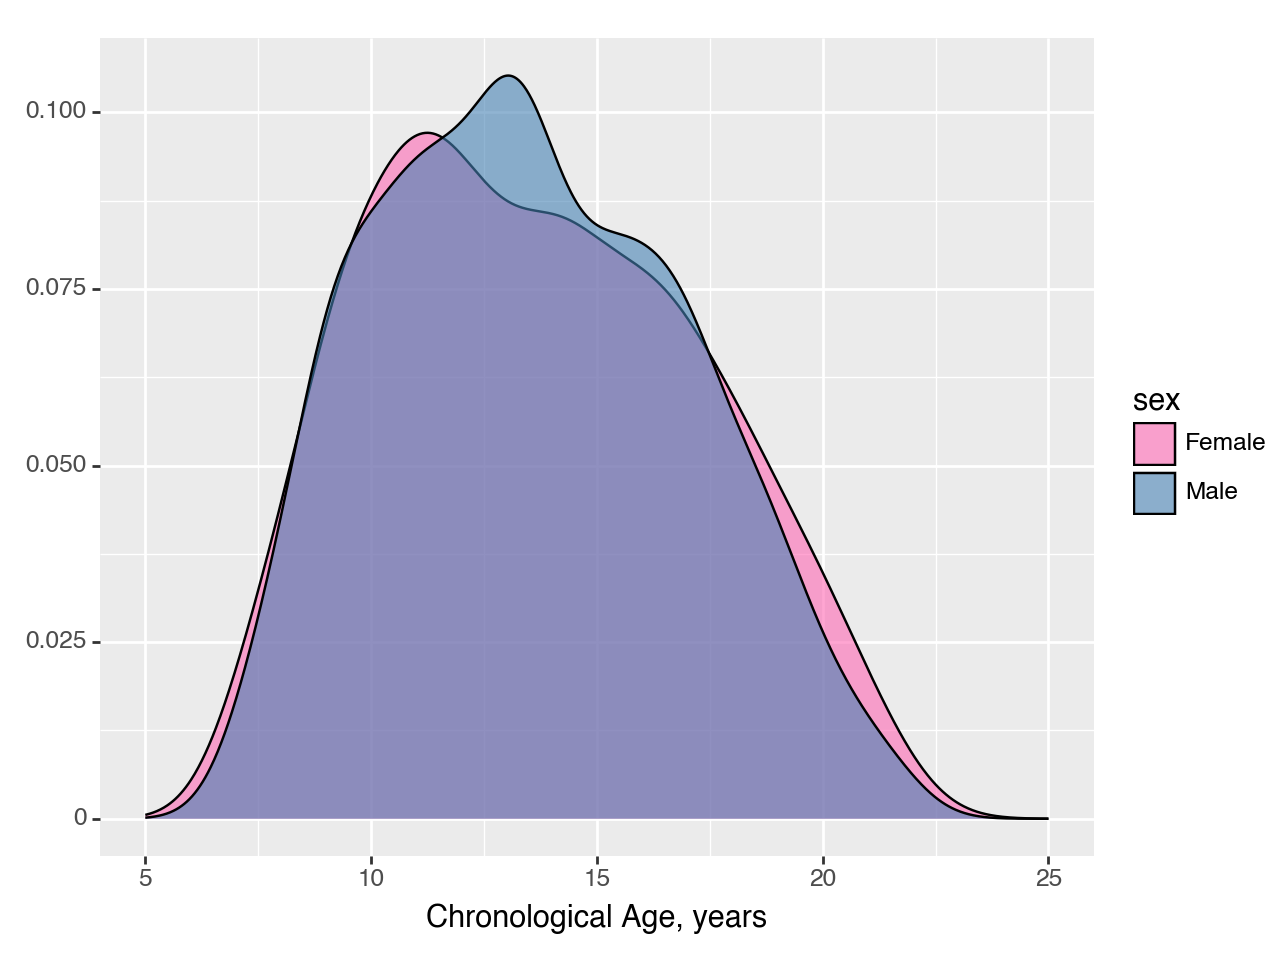

In [63]:
ggplot = (
    p9.ggplot(df, p9.aes(x="chronological_age", y="..density..", fill="sex"))
    + p9.geom_density(p9.aes(group="sex"), alpha=0.6)
    + p9.scale_fill_manual(values=["#FF69B4", "#4682B4"])
    + p9.labs(x="Chronological Age, years", y="", fill="sex")  
    + p9.xlim(5, 25)
)
print(ggplot)

#### A little data cleaning

In [64]:
df['anxiety'] = df['anxiety'].apply(lambda x: 'Yes' if x == 2.0 else 'No')
df['depression'] = df['depression'].apply(lambda x: 'Yes' if x == 2.0 else 'No')
df['adhd'] = df['adhd'].apply(lambda x: 'Yes' if x == 2.0 else 'No')
df['cantpsych'] = df['cantpsych'].apply(lambda x: 'Yes' if x == 3.0 else 'No')
df['past_antpsych'] = df['past_antpsych'].apply(lambda x: 'Yes' if x == 3.0 else 'No')

In [65]:
df.to_csv(f"{here()}/data/processed/{datem}_bhrc_all_waves.csv", index=False)

### THE END